<a href="https://colab.research.google.com/github/thefortunetella/Iris_Classification_NN/blob/main/common_experiment_functions_iris_classifc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#packages
!pip install pandas
!pip install tensorflow
!pip install sklearn
!pip install matplotlib

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.



******************************************************
Model: "Iris-Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense-Layer-0 (Dense)       (None, 32)                160       
                                                                 
 Dense-Layer-1 (Dense)       (None, 64)                2112      
                                                                 
 Output-Layer (Dense)        (None, 3)                 195       
                                                                 
Total params: 2467 (9.64 KB)
Trainable params: 2467 (9.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
8/8 [==============================] - 4s 150ms/step - loss: 1.0450 - accuracy: 0.6750 - val_loss: 0.9886 - val_accuracy: 0.8667
Epoch 2/10
8/8 [==============================] - 0s 12ms/step - loss: 0.9357 - accuracy: 0.

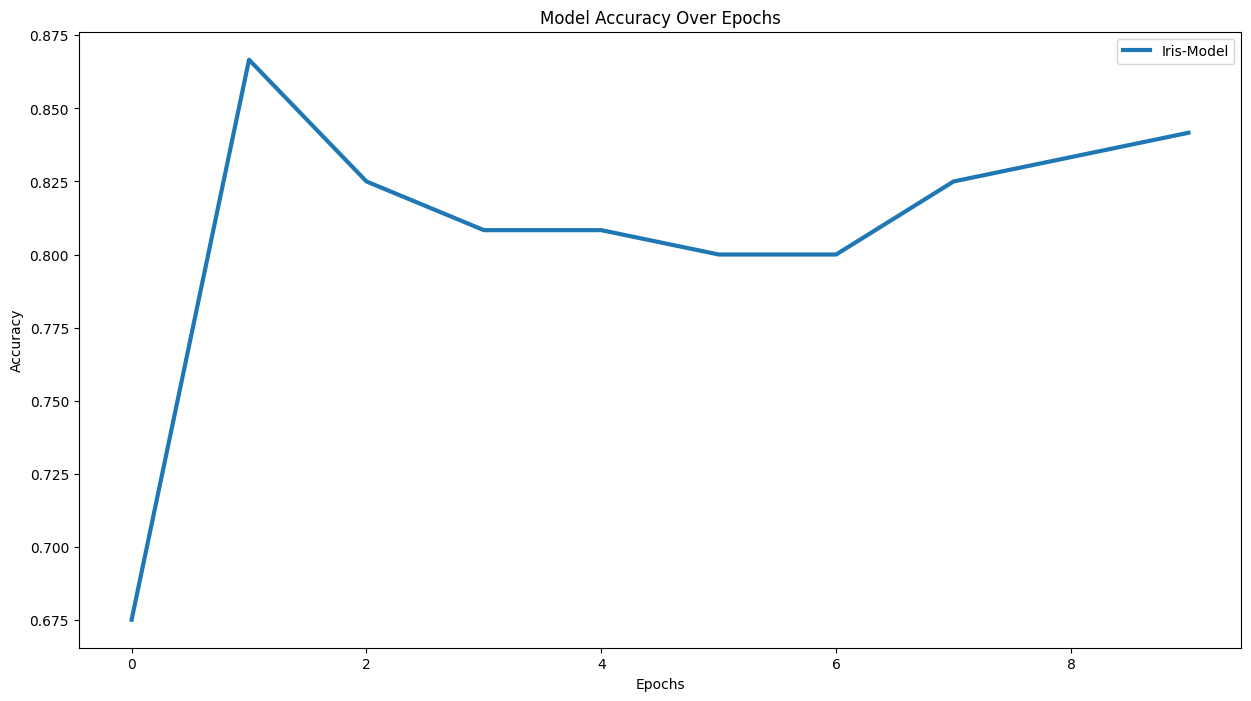

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Function to convert Flower names to numeric values
def type_to_numeric(x):
    if x == 'setosa':
        return 0
    elif x == 'versicolor':
        return 1
    else:
        return 2

# Read data and process
def get_data():
    iris_data = pd.read_csv("iris.csv")

    # Use a Label encoder to convert String to numeric values for the target variable
    label_encoder = preprocessing.LabelEncoder()
    iris_data['Species'] = label_encoder.fit_transform(iris_data['Species'])

    # Convert input to numpy array
    np_iris = iris_data.to_numpy()

    # Separate feature and target variables
    X_data = np_iris[:, 0:4]
    Y_data = np_iris[:, 4]

    # Create scaler model that is fit on the input data
    scaler = StandardScaler().fit(X_data)

    # Scale numeric features
    X_data = scaler.transform(X_data)

    # Convert target variable to a one-hot-encoding array
    Y_data = tf.keras.utils.to_categorical(Y_data, 3)

    # Return feature and target variables
    return X_data, Y_data

# Function to create the default configuration for the model. This will be overridden as required during experimentation
def base_model_config():
    model_config = {
        "HIDDEN_NODES": [32, 64],
        "HIDDEN_ACTIVATION": "relu",
        "OUTPUT_NODES": 3,
        "OUTPUT_ACTIVATION": "softmax",
        "WEIGHTS_INITIALIZER": "random_normal",
        "BIAS_INITIALIZER": "zeros",
        "NORMALIZATION": "none",
        "OPTIMIZER": "rmsprop",
        "LEARNING_RATE": 0.001,
        "REGULARIZER": None,
        "DROPOUT_RATE": 0.0,
        "EPOCHS": 10,
        "BATCH_SIZE": 16,
        "VALIDATION_SPLIT": 0.2,
        "VERBOSE": 1,
        "LOSS_FUNCTION": "categorical_crossentropy",
        "METRICS": ["accuracy"]
    }
    return model_config

# Function to create an optimizer based on the optimizer name and learning rate
def get_optimizer(optimizer_name, learning_rate):
    if optimizer_name == 'adagrad':
        optimizer = keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    return optimizer

# Function to create a model and fit the model
def create_and_run_model(model_config, X, Y, model_name):
    model = tf.keras.models.Sequential(name=model_name)

    for layer in range(len(model_config['HIDDEN_NODES'])):
        if layer == 0:
            model.add(
                keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                                   input_shape=(X.shape[1],),
                                   name="Dense-Layer-" + str(layer),
                                   kernel_initializer=model_config["WEIGHTS_INITIALIZER"],
                                   bias_initializer=model_config["BIAS_INITIALIZER"],
                                   kernel_regularizer=model_config["REGULARIZER"],
                                   activation=model_config["HIDDEN_ACTIVATION"]))
        else:
            if model_config["NORMALIZATION"] == "batch":
                model.add(keras.layers.BatchNormalization())

            if model_config["DROPOUT_RATE"] > 0.0:
                model.add(keras.layers.Dropout(model_config["DROPOUT_RATE"]))

            model.add(
                keras.layers.Dense(model_config["HIDDEN_NODES"][layer],
                                   name="Dense-Layer-" + str(layer),
                                   kernel_initializer=model_config["WEIGHTS_INITIALIZER"],
                                   bias_initializer=model_config["BIAS_INITIALIZER"],
                                   kernel_regularizer=model_config["REGULARIZER"],
                                   activation=model_config["HIDDEN_ACTIVATION"]))

    model.add(keras.layers.Dense(model_config["OUTPUT_NODES"],
                                 name="Output-Layer",
                                 activation=model_config["OUTPUT_ACTIVATION"]))

    optimizer = get_optimizer(model_config["OPTIMIZER"], model_config["LEARNING_RATE"])

    model.compile(loss=model_config["LOSS_FUNCTION"],
                  optimizer=optimizer,
                  metrics=model_config["METRICS"])

    print("\n******************************************************")
    model.summary()

    X_train, X_val, Y_train, Y_val = train_test_split(
        X, Y, stratify=Y, test_size=model_config["VALIDATION_SPLIT"])

    history = model.fit(X_train,
                        Y_train,
                        batch_size=model_config["BATCH_SIZE"],
                        epochs=model_config["EPOCHS"],
                        verbose=model_config["VERBOSE"],
                        validation_data=(X_val, Y_val))

    return history

# Function to plot a graph based on the results derived
def plot_graph(accuracy_measures, title):
    plt.figure(figsize=(15, 8))
    for experiment in accuracy_measures.keys():
        plt.plot(accuracy_measures[experiment], label=experiment, linewidth=3)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Main function to execute the code
def main():
    X_data, Y_data = get_data()
    model_config = base_model_config()
    history = create_and_run_model(model_config, X_data, Y_data, "Iris-Model")

    # Plotting accuracy measures
    accuracy_measures = {"Iris-Model": history.history['accuracy']}
    plot_graph(accuracy_measures, "Model Accuracy Over Epochs")

if __name__ == "__main__":
    main()
